In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Setup models to use and needed parameters for model selection
testSize = 0.25 #percentage of total set
k = 3 # for K-fold cross-validation
GBC = GradientBoostingClassifier()
RFC = RandomForestClassifier()
DTC = DecisionTreeClassifier()
ABC = AdaBoostClassifier()
linear = LogisticRegression()
models = [('Logistic regression',linear,RFE(linear)),
          ('Gradient Boosting', GBC, SelectFromModel(GBC)),
          ('Random Forests',RFC,SelectFromModel(RFC)),
          ('Decision tree',DTC,SelectFromModel(DTC)),
          ('Adaboost',ABC,SelectFromModel(ABC))]

In [12]:
# load the data
X = pd.read_csv("../binary/X.csv",header=None).values
y = pd.read_csv("../binary/y.csv",header=None,squeeze=True).values
waveLengths = pd.read_csv("../binary/Wavelength.csv",header=None)
X_toClassify = pd.read_csv("../binary/XToClassify.csv",header=None).values

# Put aside data for testing at the end
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize)


# Do some standard normalisation
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_toClassify = scaler.transform(X_toClassify)


In [13]:
# Get a baseline accruaccy
linear = LogisticRegression()
linear_selector = RFE(linear)
linear.fit(X_train,y_train)
f1_score(linear.predict(X_train),y_train)

1.0

In [14]:
# Setup a dataframe to contain the results
results = pd.DataFrame(columns=['Algorithm',
                                'Mean score',
                                'Total operation time',
                                'Number of important features',
                                "Feature set"])

# Loop over the models and test their performance using cross validation and the f1 score
for name, model, selector in models:
    scores = cross_validate(model,X_train,y_train,cv=k,scoring='f1')
    
    # Can we do just as well with fewer features?
    selector.fit(X_train,y_train)
    X_reduced = selector.transform(X_train)
    scores_reduced = cross_validate(model,X_reduced,y_train,cv=k,scoring='f1')

    results.loc[len(results)] = pd.Series({
        'Algorithm' : name,
        "Mean score":scores['test_score'].mean(),
        "Total operation time" : sum(scores['fit_time'])+sum(scores['score_time']),
        "Number of important features":sum(selector.get_support()),
        "Feature set" : "Full"})
    results.loc[len(results)] = pd.Series({
        'Algorithm' : name,
        "Number of important features":sum(selector.get_support()),
        "Mean score":scores_reduced['test_score'].mean(),
        "Total operation time" : sum(scores_reduced['fit_time'])+sum(scores_reduced['score_time']),
        "Feature set":"reduced"})                                                                                                                                                 
    


# calculate the 'rating' to determine the best model. Based on accuracy and operation time. Higher is better 
results['Rating'] = results['Mean score'] /results['Total operation time']
results.sort_values('Rating',ascending=False,inplace=True)
bestModelRecord = results.iloc[0]
results

,Algorithm,Mean score,Total operation time,Number of important features,Feature set,Rating
7,Decision tree,1.0,0.005992,1,reduced,166.884335
9,Adaboost,1.0,0.010062,1,reduced,99.384025
1,Logistic regression,1.0,0.021063,460,reduced,47.477491
0,Logistic regression,1.0,0.040967,460,Full,24.409898
6,Decision tree,1.0,0.047222,1,Full,21.176509
8,Adaboost,1.0,0.053763,1,Full,18.600100
5,Random Forests,1.0,0.070952,10,reduced,14.094095
4,Random Forests,1.0,0.077141,10,Full,12.963347
3,Gradient Boosting,1.0,0.193892,72,reduced,5.157517
2,Gradient Boosting,1.0,1.080912,72,Full,0.925145


In [15]:
# Find the best model
for name,model,selector in models:
    if name == bestModelRecord['Algorithm']:
        bestModel = model
        bestSelector = selector
        
# Train the best model on the reduced feature set and report the accuracy
bestModel.fit(bestSelector.fit_transform(X_train,y_train),y_train)
f1_score(bestModel.predict(bestSelector.transform(X_test)),y_test)

1.0

In [16]:
# Use trained model to predict and store the results of the samples to classify
# Note that X_toClassify was already normalised
pd.DataFrame(bestModel.predict(bestSelector.transform(X_toClassify))).to_csv("../binary/PredictedClasses.csv",index=False)

In [17]:
# Put the best features and the labels in one dataframe so we can easily plot them
bestFeatures = bestSelector.get_support()
df = pd.concat([
        pd.DataFrame(X[:,bestFeatures],columns=["{:.3f}".format(numb) + " nm" for wl in waveLengths[bestFeatures].values.tolist() for numb in wl ]),
        pd.DataFrame(y,columns=["Catagory"])]
    ,axis=1)
df.head()

,637.352 nm,Catagory
0,55.16,1
1,10.81,0
2,50.74,1
3,50.99,1
4,52.40,1


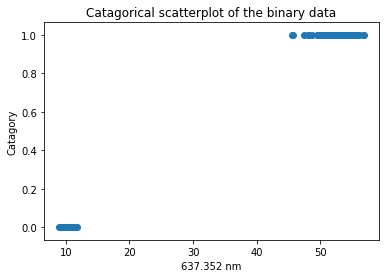

In [18]:
plt.scatter(x=df.iloc[:,0],y=df.iloc[:,1])
plt.title("Catagorical scatterplot of the binary data")
plt.ylabel("Catagory")
plt.xlabel(df.columns[0])
plt.savefig('../tex/binaryScatterplot.png')
plt.show()

In [10]:
print(results.to_latex())

\begin{tabular}{llrrllr}
\toprule
{} &            Algorithm &  Mean score &  Total operation time & Number of important features & Feature set &      Rating \\
\midrule
7 &        Decision tree &         1.0 &              0.003655 &                            1 &     reduced &  273.618892 \\
9 &             Adaboost &         1.0 &              0.008293 &                            1 &     reduced &  120.581417 \\
1 &  Logistic regression &         1.0 &              0.019660 &                          460 &     reduced &   50.864093 \\
6 &        Decision tree &         1.0 &              0.026309 &                            1 &        Full &   38.010476 \\
8 &             Adaboost &         1.0 &              0.031199 &                            1 &        Full &   32.051842 \\
5 &       Random Forests &         1.0 &              0.049511 &                           10 &     reduced &   20.197355 \\
0 &  Logistic regression &         1.0 &              0.050313 &                 